In [548]:
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt

from keras import __version__

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

from keras.optimizers import SGD
from keras.models import load_model
from keras.models import save_model

from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


In [547]:
import pandas as pd
import numpy as np
from six import StringIO
import collections
from copy import copy

import mhcnames

from mhcnames import normalize_allele_name

import sklearn
import scipy


from sklearn.metrics import f1_score, accuracy_score

from sklearn.model_selection import train_test_split

In [545]:
import mhcflurry
from mhcflurry import Class1AffinityPredictor, Class1NeuralNetwork, scoring, select_allele_specific_models_command
from mhcflurry.downloads import get_path
from mhcflurry.amino_acid import index_encoding, fixed_vectors_encoding, available_vector_encodings, vector_encoding_length, COMMON_AMINO_ACIDS, ENCODING_DATA_FRAMES, AMINO_ACID_INDEX, BLOSUM62_MATRIX
from mhcflurry import encodable_sequences

In [377]:
#get data path
data_path = get_path("data_curated", "curated_training_data.no_mass_spec.csv.bz2")

#read training data
df = pandas.read_csv(data_path)

df.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
0,BoLA-1*21:01,AENDTLVVSV,7817.0,=,quantitative,Barlow - purified MHC/competitive/fluorescence,BoLA-1*02101
1,BoLA-1*21:01,NQFNGGCLLV,1086.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-1*02101
2,BoLA-2*08:01,AAHCIHAEW,21.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
3,BoLA-2*08:01,AAKHMSNTY,1299.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
4,BoLA-2*08:01,DSYAYMRNGW,2.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801


In [16]:
#only select peptide between 8 to 15
df = df.loc[(df.peptide.str.len() >= 8) & (df.peptide.str.len() <= 15)]

df.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
0,BoLA-1*21:01,AENDTLVVSV,7817.0,=,quantitative,Barlow - purified MHC/competitive/fluorescence,BoLA-1*02101
1,BoLA-1*21:01,NQFNGGCLLV,1086.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-1*02101
2,BoLA-2*08:01,AAHCIHAEW,21.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
3,BoLA-2*08:01,AAKHMSNTY,1299.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
4,BoLA-2*08:01,DSYAYMRNGW,2.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801


In [26]:
hla_index = ["HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"]

HLA = df[df['allele'].isin(hla_index)]

HLA.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
15879,HLA-A*01:01,AADFPGIAR,20000.0,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-A*01:01
15880,HLA-A*01:01,AADKAAAAAY,45.0,=,quantitative,Michel - purified MHC/competitive/radioactivity,HLA-A*01:01
15881,HLA-A*01:01,AADKAAAAY,50.0,=,quantitative,Sette - purified MHC/competitive/radioactivity,HLA-A*01:01
15882,HLA-A*01:01,AADSFATSY,76.3,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-A*01:01
15883,HLA-A*01:01,AADSFATSY,1000.0,<,qualitative,Ph.D. - purified MHC/direct/radioactivity,HLA-A*01:01


In [101]:
HLA['peptide_length'] = (HLA.peptide.str.len())

HLA.groupby(['peptide_length']).count()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
peptide_length,,,,,,,
8,1325,1325,1325,1325,1325,1325,1325
9,62919,62919,62919,62919,62919,62919,62919
10,18779,18779,18779,18779,18779,18779,18779
11,1569,1569,1569,1569,1569,1569,1569
12,159,159,159,159,159,159,159
13,172,172,172,172,172,172,172
14,167,167,167,167,167,167,167
15,328,328,328,328,328,328,328


In [128]:
#predict classes

HLA["class"] = False

HLA.loc[HLA['measurement_value'] <=1, 'class'] = 'high'
HLA.loc[(HLA['measurement_value'] <=100) & (HLA['measurement_value'] >1), 'class'] = 'medium'
HLA.loc[(HLA['measurement_value'] <=10000) & (HLA['measurement_value'] >100), 'class'] = 'low'
HLA.loc[HLA['measurement_value'] >=10000, 'class'] = 'non'

HLA.groupby(["class"]).count()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,peptide_length
class,,,,,,,,
high,1638,1638,1638,1638,1638,1638,1638,1638
low,36947,36947,36947,36947,36947,36947,36947,36947
medium,13452,13452,13452,13452,13452,13452,13452,13452
non,33381,33381,33381,33381,33381,33381,33381,33381


In [246]:
HLA["class_code"] = HLA["class"].astype('category').cat.codes

HLA.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,peptide_length,class,subset,class_code
15879,HLA-A*01:01,AADFPGIAR,20000.0,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,9,non,train,3
15880,HLA-A*01:01,AADKAAAAAY,45.0,=,quantitative,Michel - purified MHC/competitive/radioactivity,HLA-A*01:01,10,medium,train,2
15881,HLA-A*01:01,AADKAAAAY,50.0,=,quantitative,Sette - purified MHC/competitive/radioactivity,HLA-A*01:01,9,medium,train,2
15882,HLA-A*01:01,AADSFATSY,76.3,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,9,medium,train,2
15883,HLA-A*01:01,AADSFATSY,1000.0,<,qualitative,Ph.D. - purified MHC/direct/radioactivity,HLA-A*01:01,9,low,train,1


In [247]:
HLA.groupby(["allele"]).count()

,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,peptide_length,class,subset,class_code
allele,,,,,,,,,,
HLA-A*01:01,6153,6153,6153,6153,6153,6153,6153,6153,6153,6153
HLA-A*02:01,24629,24629,24629,24629,24629,24629,24629,24629,24629,24629
HLA-A*02:03,7846,7846,7846,7846,7846,7846,7846,7846,7846,7846
HLA-A*02:07,126,126,126,126,126,126,126,126,126,126
HLA-A*03:01,9574,9574,9574,9574,9574,9574,9574,9574,9574,9574
HLA-A*24:02,5814,5814,5814,5814,5814,5814,5814,5814,5814,5814
HLA-A*29:02,2741,2741,2741,2741,2741,2741,2741,2741,2741,2741
HLA-A*31:01,6260,6260,6260,6260,6260,6260,6260,6260,6260,6260
HLA-A*68:02,7223,7223,7223,7223,7223,7223,7223,7223,7223,7223


In [355]:
#split into training and testing

allele = "HLA-A*02:01"
allele_oi = HLA[HLA.allele == allele]

allele_oi.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,peptide_length,class,subset,class_code
22035,HLA-A*02:01,AAAAATPSATL,5000.0,>,qualitative,Heemskerk - purified MHC/direct/fluorescence,HLA-A2,11,low,train,1
22036,HLA-A*02:01,AAAAEEEEE,5000.0,>,qualitative,Grubeck-Loebenstein - cellular MHC/direct/fluo...,HLA-A*02:01,9,low,train,1
22037,HLA-A*02:01,AAAAGWQTL,5000.0,<,qualitative,Wen - cellular MHC/direct/fluorescence,HLA-A*02:01,9,low,train,1
22038,HLA-A*02:01,AAAATCALV,41.0,=,quantitative,Sette - purified MHC/competitive/radioactivity,HLA-A*02:01,9,medium,train,2
22039,HLA-A*02:01,AAAATPSATL,5000.0,>,qualitative,Heemskerk - purified MHC/direct/fluorescence,HLA-A2,10,low,test,1


In [346]:

np.random.seed(4060)
test_samples = allele_oi.reset_index().groupby('peptide_length')["index"].apply(lambda x: x.sample(frac=.1))

In [347]:
# assign test set
allele_oi.loc[:,("subset")] = "train"
allele_oi.loc[test_samples, ("subset")] = "test"

allele_oi.groupby(["subset", "peptide_length"]).count()

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


allele  peptide  measurement_value  \
subset peptide_length                                       
test   8                   26       26                 26   
       9                 1779     1779               1779   
       10                 566      566                566   
       11                  56       56                 56   
       12                   6        6                  6   
       13                   3        3                  3   
       14                   7        7                  7   
       15                  21       21                 21   
train  8                  237      237                237   
       9                16011    16011              16011   
       10                5089     5089               5089   
       11                 499      499                499   
       12                  50       50                 50   
       13                  29       29                 29   
       14                  60       60                 60   
       15                 190      190                190   
       train                1        1                  1   

                       measurement_inequality  measurement_type  \
subset peptide_length                                             
test   8                                   26                26   
       9                                 1779              1779   
       10                                 566               566   
       11                                  56                56   
       12                                   6                 6   
       13                                   3                 3   
       14                                   7                 7   
       15                                  21                21   
train  8                                  237               237   
       9                                16011             16011   
       10                                5089              5089   
       11                                 499               499   
       12                                  50                50   
       13                                  29                29   
       14                                  60                60   
       15                                 190               190   
       train                                1                 1   

                       measurement_source  original_allele  class  class_code  
subset peptide_length                                                          
test   8                               26               26     26          26  
       9                             1779             1779   1779        1779  
       10                             566              566    566         566  
       11                              56               56     56          56  
       12                               6                6      6           6  
       13                               3                3      3           3  
       14                               7                7      7           7  
       15                              21               21     21          21  
train  8                              237              237    237         237  
       9                            16011            16011  16011       16011  
       10                            5089             5089   5089        5089  
       11                             499              499    499         499  
       12                              50               50     50          50  
       13                              29               29     29          29  
       14                              60               60     60          60  
       15                             190              190    190         190  
       train                            1                1      1           1

In [252]:
train = allele_oi[allele_oi["subset"] == "train"]

test = allele_oi[allele_oi["subset"] == "test"]


X_train_pre = np.array(train["peptide"])
y_train_pre = np.array(train["class_code"])
X_test_pre = np.array(test["peptide"])
y_test_pre = np.array(test["class_code"])

In [254]:
X_train = encodable_sequences.EncodableSequences.sequences_to_fixed_length_index_encoded_array(X_train_pre)
X_test = encodable_sequences.EncodableSequences.sequences_to_fixed_length_index_encoded_array(X_test_pre)

X_test

array([[ 0,  0,  0, ...,  6,  9,  1],
       [ 0,  0,  0, ...,  9, 16, 17],
       [ 0,  0,  0, ..., 17,  7, 17],
       ...,
       [19, 17, 15, ...,  9,  6,  9],
       [19, 17, 15, ..., 15, 15,  7],
       [19, 17, 18, ..., 17,  7, 19]])

In [255]:
X_train_ = fixed_vectors_encoding(X_train, BLOSUM62_MATRIX) 
X_test_ = fixed_vectors_encoding(X_test, BLOSUM62_MATRIX) 


In [256]:
input_shape = 315
n_class = 4

X_train_ = np.reshape(X_train_, (X_train_.shape[0], input_shape))

X_test_ = np.reshape(X_test_, (X_test_.shape[0], input_shape))



In [257]:
#transform data for model

X_train_.shape

(22165, 315)

In [264]:



y_train = to_categorical(y_train_pre, num_classes=n_class, dtype='float32')
y_test = to_categorical(y_test_pre, num_classes=n_class, dtype='float32')

y_test.shape

(2464, 4)

In [298]:
#construct keras model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(315, activation='relu', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 315)               99540     
_________________________________________________________________
dropout_17 (Dropout)         (None, 315)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 150)               47400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 604       
Total params: 147,544
Trainable params: 147,544
Non-trainable params: 0
_________________________________________________________________


In [299]:
#compile and train

history = model.fit(
    X_train_,
    y_train,
    epochs=100,
    batch_size=80,
    validation_split=0.1,
    verbose=1,
        
)


Train on 19948 samples, validate on 2217 samples
Epoch 1/100
19948/19948 [==============================] - ETA: 49s - loss: 2.0347 - acc: 0.28 - ETA: 2s - loss: 1.5170 - acc: 0.4538 - ETA: 1s - loss: 1.3077 - acc: 0.481 - ETA: 0s - loss: 1.2084 - acc: 0.493 - ETA: 0s - loss: 1.1471 - acc: 0.503 - ETA: 0s - loss: 1.1031 - acc: 0.513 - ETA: 0s - loss: 1.0748 - acc: 0.521 - ETA: 0s - loss: 1.0496 - acc: 0.526 - ETA: 0s - loss: 1.0293 - acc: 0.532 - ETA: 0s - loss: 1.0136 - acc: 0.536 - ETA: 0s - loss: 1.0016 - acc: 0.539 - ETA: 0s - loss: 0.9897 - acc: 0.542 - 1s 41us/step - loss: 0.9889 - acc: 0.5431 - val_loss: 0.9113 - val_acc: 0.5544
Epoch 2/100
19948/19948 [==============================] - ETA: 0s - loss: 0.7919 - acc: 0.625 - ETA: 0s - loss: 0.8819 - acc: 0.577 - ETA: 0s - loss: 0.8598 - acc: 0.575 - ETA: 0s - loss: 0.8489 - acc: 0.580 - ETA: 0s - loss: 0.8475 - acc: 0.583 - ETA: 0s - loss: 0.8434 - acc: 0.583 - ETA: 0s - loss: 0.8451 - acc: 0.585 - ETA: 0s - loss: 0.8450 - acc: 0

19948/19948 [==============================] - ETA: 0s - loss: 0.7242 - acc: 0.675 - ETA: 0s - loss: 0.6283 - acc: 0.713 - ETA: 0s - loss: 0.6267 - acc: 0.711 - ETA: 0s - loss: 0.6304 - acc: 0.711 - ETA: 0s - loss: 0.6368 - acc: 0.703 - ETA: 0s - loss: 0.6348 - acc: 0.704 - ETA: 0s - loss: 0.6363 - acc: 0.702 - ETA: 0s - loss: 0.6415 - acc: 0.701 - ETA: 0s - loss: 0.6451 - acc: 0.700 - ETA: 0s - loss: 0.6460 - acc: 0.701 - 1s 25us/step - loss: 0.6479 - acc: 0.7009 - val_loss: 0.9861 - val_acc: 0.5390
Epoch 17/100
19948/19948 [==============================] - ETA: 0s - loss: 0.7831 - acc: 0.637 - ETA: 0s - loss: 0.6292 - acc: 0.701 - ETA: 0s - loss: 0.6140 - acc: 0.712 - ETA: 0s - loss: 0.6230 - acc: 0.704 - ETA: 0s - loss: 0.6344 - acc: 0.698 - ETA: 0s - loss: 0.6355 - acc: 0.695 - ETA: 0s - loss: 0.6365 - acc: 0.696 - ETA: 0s - loss: 0.6384 - acc: 0.694 - ETA: 0s - loss: 0.6363 - acc: 0.696 - ETA: 0s - loss: 0.6413 - acc: 0.695 - 0s 25us/step - loss: 0.6420 - acc: 0.6957 - val_loss: 

19948/19948 [==============================] - ETA: 0s - loss: 0.5648 - acc: 0.712 - ETA: 0s - loss: 0.5435 - acc: 0.755 - ETA: 0s - loss: 0.5540 - acc: 0.751 - ETA: 0s - loss: 0.5539 - acc: 0.748 - ETA: 0s - loss: 0.5597 - acc: 0.744 - ETA: 0s - loss: 0.5646 - acc: 0.743 - ETA: 0s - loss: 0.5689 - acc: 0.740 - ETA: 0s - loss: 0.5710 - acc: 0.738 - ETA: 0s - loss: 0.5716 - acc: 0.739 - ETA: 0s - loss: 0.5730 - acc: 0.738 - 0s 24us/step - loss: 0.5734 - acc: 0.7377 - val_loss: 1.2053 - val_acc: 0.5129
Epoch 32/100
19948/19948 [==============================] - ETA: 0s - loss: 0.7667 - acc: 0.650 - ETA: 0s - loss: 0.5512 - acc: 0.746 - ETA: 0s - loss: 0.5616 - acc: 0.738 - ETA: 0s - loss: 0.5688 - acc: 0.733 - ETA: 0s - loss: 0.5690 - acc: 0.734 - ETA: 0s - loss: 0.5720 - acc: 0.735 - ETA: 0s - loss: 0.5737 - acc: 0.736 - ETA: 0s - loss: 0.5749 - acc: 0.734 - ETA: 0s - loss: 0.5748 - acc: 0.736 - ETA: 0s - loss: 0.5773 - acc: 0.735 - 0s 25us/step - loss: 0.5772 - acc: 0.7347 - val_loss: 

19948/19948 [==============================] - ETA: 1s - loss: 0.5937 - acc: 0.725 - ETA: 0s - loss: 0.5092 - acc: 0.776 - ETA: 0s - loss: 0.5379 - acc: 0.762 - ETA: 0s - loss: 0.5380 - acc: 0.757 - ETA: 0s - loss: 0.5417 - acc: 0.754 - ETA: 0s - loss: 0.5472 - acc: 0.752 - ETA: 0s - loss: 0.5489 - acc: 0.751 - ETA: 0s - loss: 0.5467 - acc: 0.753 - ETA: 0s - loss: 0.5465 - acc: 0.753 - ETA: 0s - loss: 0.5482 - acc: 0.752 - ETA: 0s - loss: 0.5496 - acc: 0.751 - ETA: 0s - loss: 0.5519 - acc: 0.749 - 1s 30us/step - loss: 0.5517 - acc: 0.7493 - val_loss: 1.3095 - val_acc: 0.5165
Epoch 48/100
19948/19948 [==============================] - ETA: 0s - loss: 0.5099 - acc: 0.812 - ETA: 0s - loss: 0.5359 - acc: 0.757 - ETA: 0s - loss: 0.5455 - acc: 0.756 - ETA: 0s - loss: 0.5441 - acc: 0.757 - ETA: 0s - loss: 0.5469 - acc: 0.755 - ETA: 0s - loss: 0.5446 - acc: 0.753 - ETA: 0s - loss: 0.5461 - acc: 0.752 - ETA: 0s - loss: 0.5483 - acc: 0.753 - ETA: 0s - loss: 0.5474 - acc: 0.752 - ETA: 0s - loss: 

Epoch 62/100
19948/19948 [==============================] - ETA: 0s - loss: 0.4699 - acc: 0.725 - ETA: 0s - loss: 0.5150 - acc: 0.772 - ETA: 0s - loss: 0.5168 - acc: 0.767 - ETA: 0s - loss: 0.5248 - acc: 0.769 - ETA: 0s - loss: 0.5264 - acc: 0.768 - ETA: 0s - loss: 0.5330 - acc: 0.765 - ETA: 0s - loss: 0.5289 - acc: 0.765 - ETA: 0s - loss: 0.5318 - acc: 0.764 - ETA: 0s - loss: 0.5301 - acc: 0.763 - ETA: 0s - loss: 0.5297 - acc: 0.763 - ETA: 0s - loss: 0.5293 - acc: 0.764 - 1s 27us/step - loss: 0.5290 - acc: 0.7644 - val_loss: 1.2905 - val_acc: 0.5214
Epoch 63/100
19948/19948 [==============================] - ETA: 0s - loss: 0.5587 - acc: 0.737 - ETA: 0s - loss: 0.4842 - acc: 0.786 - ETA: 0s - loss: 0.4878 - acc: 0.778 - ETA: 0s - loss: 0.4898 - acc: 0.777 - ETA: 0s - loss: 0.5035 - acc: 0.772 - ETA: 0s - loss: 0.5137 - acc: 0.770 - ETA: 0s - loss: 0.5188 - acc: 0.769 - ETA: 0s - loss: 0.5241 - acc: 0.766 - ETA: 0s - loss: 0.5218 - acc: 0.768 - ETA: 0s - loss: 0.5220 - acc: 0.768 - 1s 

19948/19948 [==============================] - ETA: 0s - loss: 0.6277 - acc: 0.737 - ETA: 0s - loss: 0.5383 - acc: 0.760 - ETA: 0s - loss: 0.5191 - acc: 0.771 - ETA: 0s - loss: 0.5139 - acc: 0.772 - ETA: 0s - loss: 0.5272 - acc: 0.764 - ETA: 0s - loss: 0.5226 - acc: 0.767 - ETA: 0s - loss: 0.5225 - acc: 0.766 - ETA: 0s - loss: 0.5249 - acc: 0.766 - ETA: 0s - loss: 0.5259 - acc: 0.764 - ETA: 0s - loss: 0.5273 - acc: 0.764 - 0s 25us/step - loss: 0.5282 - acc: 0.7639 - val_loss: 1.4531 - val_acc: 0.4980
Epoch 78/100
19948/19948 [==============================] - ETA: 0s - loss: 0.5395 - acc: 0.725 - ETA: 0s - loss: 0.5054 - acc: 0.777 - ETA: 0s - loss: 0.4978 - acc: 0.786 - ETA: 0s - loss: 0.5065 - acc: 0.779 - ETA: 0s - loss: 0.5129 - acc: 0.775 - ETA: 0s - loss: 0.5196 - acc: 0.771 - ETA: 0s - loss: 0.5251 - acc: 0.768 - ETA: 0s - loss: 0.5254 - acc: 0.766 - ETA: 0s - loss: 0.5269 - acc: 0.764 - ETA: 0s - loss: 0.5249 - acc: 0.766 - ETA: 0s - loss: 0.5261 - acc: 0.766 - 1s 29us/step - l

19948/19948 [==============================] - ETA: 0s - loss: 0.3513 - acc: 0.850 - ETA: 0s - loss: 0.4777 - acc: 0.791 - ETA: 0s - loss: 0.5082 - acc: 0.770 - ETA: 0s - loss: 0.5197 - acc: 0.771 - ETA: 0s - loss: 0.5124 - acc: 0.772 - ETA: 0s - loss: 0.5111 - acc: 0.773 - ETA: 0s - loss: 0.5145 - acc: 0.774 - ETA: 0s - loss: 0.5183 - acc: 0.771 - ETA: 0s - loss: 0.5183 - acc: 0.769 - ETA: 0s - loss: 0.5182 - acc: 0.769 - 1s 25us/step - loss: 0.5191 - acc: 0.7691 - val_loss: 1.4143 - val_acc: 0.5138
Epoch 93/100
19948/19948 [==============================] - ETA: 0s - loss: 0.4393 - acc: 0.775 - ETA: 0s - loss: 0.4837 - acc: 0.783 - ETA: 0s - loss: 0.4991 - acc: 0.776 - ETA: 0s - loss: 0.5061 - acc: 0.772 - ETA: 0s - loss: 0.5069 - acc: 0.772 - ETA: 0s - loss: 0.5021 - acc: 0.774 - ETA: 0s - loss: 0.5027 - acc: 0.774 - ETA: 0s - loss: 0.5081 - acc: 0.772 - ETA: 0s - loss: 0.5080 - acc: 0.772 - ETA: 0s - loss: 0.5120 - acc: 0.771 - 0s 24us/step - loss: 0.5106 - acc: 0.7715 - val_loss: 

In [300]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

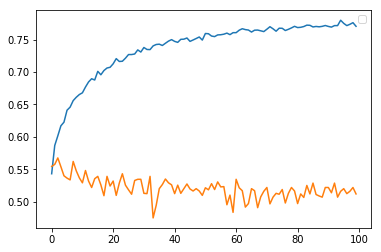

In [313]:



plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend()

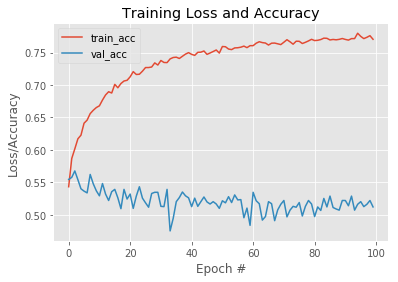

In [320]:
plot_history(history)

In [304]:
train.groupby(["class"]).count()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,peptide_length,subset,class_code
class,,,,,,,,,,
high,636,636,636,636,636,636,636,636,636,636
low,11740,11740,11740,11740,11740,11740,11740,11740,11740,11740
medium,4199,4199,4199,4199,4199,4199,4199,4199,4199,4199
non,5590,5590,5590,5590,5590,5590,5590,5590,5590,5590


In [305]:
model.metrics_names

['loss', 'acc']

In [306]:
model.evaluate(X_test_, y_test)

2464/2464 [==============================] - ETA:  - 0s 19us/step


[0.9240798590245185, 0.6371753246753247]

In [351]:
def get_train_test (HLA, allele, test_frac):
    #get desired allele data
    allele_oi = HLA[HLA.allele == allele]
    
    #distribute between train and test sets
    np.random.seed(4060)
    test_samples = allele_oi.reset_index().groupby('peptide_length')["index"].apply(lambda x: x.sample(frac=test_frac))
    
    allele_oi.loc[:,"subset"] = "train"
    allele_oi.loc[test_samples, "subset"] = "test"

    #extract train and test sets
    train = allele_oi[allele_oi["subset"] == "train"]

    test = allele_oi[allele_oi["subset"] == "test"]

    #assign 
    X_train_pre = np.array(train["peptide"])
    y_train_pre = np.array(train["class_code"])
    X_test_pre = np.array(test["peptide"])
    y_test_pre = np.array(test["class_code"])
    
    return X_train_pre, y_train_pre, X_test_pre, y_test_pre

In [331]:
def encode_flatten (X_train_pre, X_test_pre):
    #encode peptide to fixed length and index
    X_train = encodable_sequences.EncodableSequences.sequences_to_fixed_length_index_encoded_array(X_train_pre)
    X_test = encodable_sequences.EncodableSequences.sequences_to_fixed_length_index_encoded_array(X_test_pre)
    
    #fixed vector encoding to BLOSUM62
    X_train_ = fixed_vectors_encoding(X_train, BLOSUM62_MATRIX) 
    X_test_ = fixed_vectors_encoding(X_test, BLOSUM62_MATRIX) 
    
    #flatten
        
    input_shape = 315
    n_class = 4

    X_train_ = np.reshape(X_train_, (X_train_.shape[0], input_shape))

    X_test_ = np.reshape(X_test_, (X_test_.shape[0], input_shape))
    
    return X_train_, X_test_

In [309]:
def y_categorical (y_train_pre, y_test_pre, n_class):
    #one hot encode categories
    y_train = to_categorical(y_train_pre, num_classes=n_class, dtype='float32')
    y_test = to_categorical(y_test_pre, num_classes=n_class, dtype='float32')
    
    return y_train, y_test


In [371]:
def plot_history(history, allele):
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    #plt.plot(history.history["loss"], label="train_loss")
    #plt.plot(history.history["val_loss"], label="val_loss")
    plt.plot(history.history["acc"], label="train_acc")
    plt.plot(history.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy for allele = {}".format(allele))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")

In [463]:
allele = "HLA-A*01:01"

X_train_pre, y_train_pre, X_test_pre, y_test_pre = get_train_test (HLA = HLA, allele = allele, test_frac=0.1)

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [464]:
X_train_, X_test_ = encode_flatten (X_train_pre, X_test_pre)

In [465]:
y_train, y_test = y_categorical (y_train_pre, y_test_pre, n_class=4)

In [466]:
#construct keras model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D

# import regularizer
from keras.regularizers import l1, l2

input_shape = 315

model = Sequential()
model.add(Dense(315, activation='tanh', activity_regularizer=l2(0.0001), input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(150, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(75, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 315)               99540     
_________________________________________________________________
dropout_57 (Dropout)         (None, 315)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 150)               47400     
_________________________________________________________________
dropout_58 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_59 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 4)                 304       
Total para

In [477]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from mhcnames import normalize_allele_name

name = normalize_allele_name(allele)
file_path = ('%s_best_weight.h5' %name)

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1 )

In [478]:
#compile and train

history = model.fit(
    X_train_,
    y_train,
    epochs=100,
    batch_size=80,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint]    
)

Train on 4984 samples, validate on 554 samples
Epoch 1/100
4984/4984 [==============================] - ETA: 0s - loss: 2.1724 - acc: 0.575 - ETA: 0s - loss: 2.1020 - acc: 0.585 - ETA: 0s - loss: 2.0650 - acc: 0.596 - ETA: 0s - loss: 2.0517 - acc: 0.584 - 0s 41us/step - loss: 2.0309 - acc: 0.5825 - val_loss: 1.9893 - val_acc: 0.6137

Epoch 00001: val_acc improved from -inf to 0.61372, saving model to HLA-A_01_01_best_weight.h5
Epoch 2/100
4984/4984 [==============================] - ETA: 0s - loss: 1.8380 - acc: 0.662 - ETA: 0s - loss: 1.8896 - acc: 0.610 - ETA: 0s - loss: 1.8849 - acc: 0.601 - ETA: 0s - loss: 1.8594 - acc: 0.601 - 0s 41us/step - loss: 1.8452 - acc: 0.6001 - val_loss: 1.9711 - val_acc: 0.5776

Epoch 00002: val_acc did not improve from 0.61372
Epoch 3/100
4984/4984 [==============================] - ETA: 0s - loss: 1.6620 - acc: 0.625 - ETA: 0s - loss: 1.7454 - acc: 0.607 - ETA: 0s - loss: 1.7359 - acc: 0.601 - ETA: 0s - loss: 1.7221 - acc: 0.604 - 0s 40us/step - loss: 


Epoch 00025: val_acc did not improve from 0.62274
Epoch 26/100
4984/4984 [==============================] - ETA: 0s - loss: 0.9258 - acc: 0.575 - ETA: 0s - loss: 0.8917 - acc: 0.628 - ETA: 0s - loss: 0.8949 - acc: 0.634 - 0s 34us/step - loss: 0.8899 - acc: 0.6384 - val_loss: 1.2022 - val_acc: 0.5830

Epoch 00026: val_acc did not improve from 0.62274
Epoch 27/100
4984/4984 [==============================] - ETA: 0s - loss: 0.9204 - acc: 0.662 - ETA: 0s - loss: 0.8815 - acc: 0.647 - ETA: 0s - loss: 0.8828 - acc: 0.643 - ETA: 0s - loss: 0.8807 - acc: 0.643 - 0s 35us/step - loss: 0.8797 - acc: 0.6445 - val_loss: 1.1480 - val_acc: 0.5866

Epoch 00027: val_acc did not improve from 0.62274
Epoch 28/100
4984/4984 [==============================] - ETA: 0s - loss: 0.9265 - acc: 0.625 - ETA: 0s - loss: 0.8611 - acc: 0.658 - ETA: 0s - loss: 0.8790 - acc: 0.648 - 0s 33us/step - loss: 0.8807 - acc: 0.6411 - val_loss: 1.0378 - val_acc: 0.6227

Epoch 00028: val_acc improved from 0.62274 to 0.62274, 

4984/4984 [==============================] - ETA: 0s - loss: 1.1650 - acc: 0.525 - ETA: 0s - loss: 0.8418 - acc: 0.656 - ETA: 0s - loss: 0.8404 - acc: 0.650 - 0s 32us/step - loss: 0.8312 - acc: 0.6533 - val_loss: 1.0815 - val_acc: 0.5939

Epoch 00051: val_acc did not improve from 0.64621
Epoch 52/100
4984/4984 [==============================] - ETA: 0s - loss: 0.9776 - acc: 0.650 - ETA: 0s - loss: 0.8118 - acc: 0.662 - ETA: 0s - loss: 0.8219 - acc: 0.659 - 0s 32us/step - loss: 0.8195 - acc: 0.6605 - val_loss: 1.0864 - val_acc: 0.6209

Epoch 00052: val_acc did not improve from 0.64621
Epoch 53/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8852 - acc: 0.637 - ETA: 0s - loss: 0.8336 - acc: 0.662 - ETA: 0s - loss: 0.8266 - acc: 0.656 - 0s 32us/step - loss: 0.8268 - acc: 0.6517 - val_loss: 1.0484 - val_acc: 0.6137

Epoch 00053: val_acc did not improve from 0.64621
Epoch 54/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8944 - acc: 0.575 - ETA: 0s - l


Epoch 00077: val_acc did not improve from 0.64621
Epoch 78/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8272 - acc: 0.637 - ETA: 0s - loss: 0.7981 - acc: 0.672 - ETA: 0s - loss: 0.8092 - acc: 0.664 - 0s 31us/step - loss: 0.8050 - acc: 0.6659 - val_loss: 1.0405 - val_acc: 0.6354

Epoch 00078: val_acc did not improve from 0.64621
Epoch 79/100
4984/4984 [==============================] - ETA: 0s - loss: 0.7614 - acc: 0.775 - ETA: 0s - loss: 0.8004 - acc: 0.664 - ETA: 0s - loss: 0.7879 - acc: 0.676 - 0s 31us/step - loss: 0.7980 - acc: 0.6742 - val_loss: 1.0380 - val_acc: 0.6173

Epoch 00079: val_acc did not improve from 0.64621
Epoch 80/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8847 - acc: 0.687 - ETA: 0s - loss: 0.8009 - acc: 0.667 - ETA: 0s - loss: 0.7956 - acc: 0.669 - 0s 31us/step - loss: 0.7964 - acc: 0.6655 - val_loss: 1.0849 - val_acc: 0.6119

Epoch 00080: val_acc did not improve from 0.64621
Epoch 81/100
4984/4984 [===================

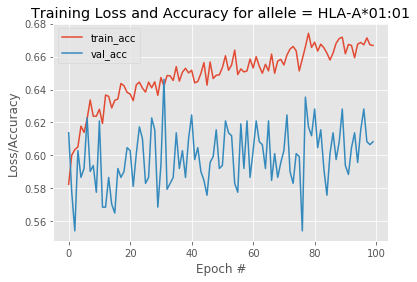

In [479]:
plot_history(history, allele)

In [480]:
model.metrics_names

['loss', 'acc']

In [484]:
metrics = model.evaluate(X_test_, y_test)

615/615 [==============================] - ETA:  - 0s 28us/step


In [485]:
results = pd.DataFrame(columns = ("allele", "val_acc"))

In [486]:
results = results.append({"allele": allele, "val_acc":metrics[1]}, ignore_index=True)

results

,allele,val_acc
0,HLA-A*01:01,0.61626


In [459]:
#construct keras model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D

# import regularizer
from keras.regularizers import l1, l2

input_shape = 315

model = Sequential()
model.add(Dense(315, activation='tanh', activity_regularizer=l2(0.0001), input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(150, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(75, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 315)               99540     
_________________________________________________________________
dropout_54 (Dropout)         (None, 315)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 150)               47400     
_________________________________________________________________
dropout_55 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_56 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 4)                 304       
Total para

In [460]:
#compile and train

history = model.fit(
    X_train_,
    y_train,
    epochs=10,
    batch_size=80,
    validation_split=0.1,
    verbose=1,
        
)

Train on 19948 samples, validate on 2217 samples
Epoch 1/10
19948/19948 [==============================] - ETA: 1:55 - loss: 3.1047 - acc: 0.275 - ETA: 11s - loss: 2.7101 - acc: 0.458 - ETA: 4s - loss: 2.5912 - acc: 0.4915 - ETA: 2s - loss: 2.5111 - acc: 0.503 - ETA: 2s - loss: 2.4682 - acc: 0.507 - ETA: 1s - loss: 2.4256 - acc: 0.515 - ETA: 1s - loss: 2.3926 - acc: 0.520 - ETA: 1s - loss: 2.3686 - acc: 0.523 - ETA: 0s - loss: 2.3390 - acc: 0.526 - ETA: 0s - loss: 2.3125 - acc: 0.525 - ETA: 0s - loss: 2.2812 - acc: 0.529 - ETA: 0s - loss: 2.2543 - acc: 0.533 - ETA: 0s - loss: 2.2282 - acc: 0.534 - ETA: 0s - loss: 2.2023 - acc: 0.537 - ETA: 0s - loss: 2.1765 - acc: 0.540 - ETA: 0s - loss: 2.1537 - acc: 0.540 - 1s 67us/step - loss: 2.1459 - acc: 0.5417 - val_loss: 1.9814 - val_acc: 0.5147
Epoch 2/10
19948/19948 [==============================] - ETA: 0s - loss: 1.7737 - acc: 0.575 - ETA: 0s - loss: 1.8103 - acc: 0.551 - ETA: 0s - loss: 1.7593 - acc: 0.568 - ETA: 0s - loss: 1.7540 - acc: 

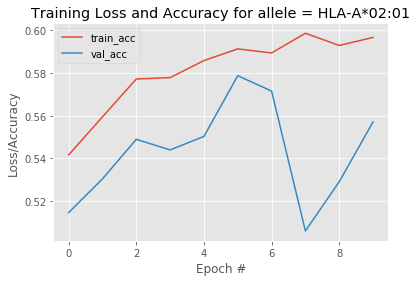

In [461]:
plot_history(history, allele)

In [462]:
acc = model.evaluate(X_test_, y_test)

results = results.append({"allele": allele, "val_acc":acc[1]}, ignore_index=True)

results

2464/2464 [==============================] - ETA:  - ETA:  - 0s 24us/step


,allele,val_acc
0,HLA-A*01:01,0.632520
1,HLA-A*02:01,0.594156


In [554]:
def model_fit_allele(allele, data, test_frac, n_class, model, epochs, results):
    allele = allele

    #set data and encode
    X_train_pre, y_train_pre, X_test_pre, y_test_pre = get_train_test (HLA = HLA, allele = allele, test_frac=test_frac)

    X_train_, X_test_ = encode_flatten (X_train_pre, X_test_pre)

    y_train, y_test = y_categorical (y_train_pre, y_test_pre, n_class=n_class)
    
    #set location to save weights
    name = normalize_allele_name(allele)
    file_path = ('%s_best_weight.h5' %name)
    checkpoint = ModelCheckpoint(file_path, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1 
                                )
    #fit model
    history = model.fit(
        X_train_,
        y_train,
        epochs=epochs,
        batch_size=80,
        validation_split=0.1,
        verbose=1,
        callbacks=[checkpoint]
    )
    


    metrics = model.evaluate(X_test_, y_test)
    y_pred = model.predict_classes(X_test_)
    pearson = scipy.stats.pearsonr(y_test_pre, y_pred)
    f1 = f1_score(y_test_pre, y_pred, average = 'weighted')
    results = results.append({"allele": allele, "val_acc":metrics[1], "f1_score":f1, "pearson_r":pearson[0]}, ignore_index=True)
    
    plot_history(history, allele)
    
    return history, metrics, results
    

In [553]:
hla_sample = hla_index[0:2]

hla_sample

['HLA-A*01:01', 'HLA-A*02:01']

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 4984 samples, validate on 554 samples
Epoch 1/100
4984/4984 [==============================] - ETA: 0s - loss: 1.0079 - acc: 0.662 - ETA: 0s - loss: 0.9929 - acc: 0.634 - ETA: 0s - loss: 0.9928 - acc: 0.635 - ETA: 0s - loss: 0.9950 - acc: 0.629 - 0s 42us/step - loss: 0.9991 - acc: 0.6264 - val_loss: 1.2597 - val_acc: 0.5884

Epoch 00001: val_acc improved from -inf to 0.58845, saving model to HLA-A_01_01_best_weight.h5
Epoch 2/100
4984/4984 [==============================] - ETA: 0s - loss: 1.0803 - acc: 0.587 - ETA: 0s - loss: 1.0104 - acc: 0.629 - ETA: 0s - loss: 0.9958 - acc: 0.634 - ETA: 0s - loss: 0.9942 - acc: 0.633 - 0s 40us/step - loss: 0.9929 - acc: 0.6348 - val_loss: 1.3887 - val_acc: 0.5379

Epoch 00002: val_acc did not improve from 0.58845
Epoch 3/100
4984/4984 [==============================] - ETA: 0s - loss: 1.0883 - acc: 0.687 - ETA: 0s - loss: 1.0175 - acc: 0.632 - ETA: 0s - loss: 0.9977 - acc: 0.635 - ETA: 0s - loss: 0.9915 - acc: 0.638 - 0s 42us/step - loss: 

Epoch 00024: val_acc did not improve from 0.60289
Epoch 25/100
4984/4984 [==============================] - ETA: 0s - loss: 0.9669 - acc: 0.612 - ETA: 0s - loss: 0.9177 - acc: 0.669 - ETA: 0s - loss: 0.9184 - acc: 0.664 - ETA: 0s - loss: 0.9324 - acc: 0.658 - 0s 34us/step - loss: 0.9312 - acc: 0.6595 - val_loss: 1.2894 - val_acc: 0.5848

Epoch 00025: val_acc did not improve from 0.60289
Epoch 26/100
4984/4984 [==============================] - ETA: 0s - loss: 1.0785 - acc: 0.575 - ETA: 0s - loss: 0.9415 - acc: 0.635 - ETA: 0s - loss: 0.9427 - acc: 0.637 - ETA: 0s - loss: 0.9402 - acc: 0.647 - ETA: 0s - loss: 0.9346 - acc: 0.651 - 0s 50us/step - loss: 0.9296 - acc: 0.6521 - val_loss: 1.2611 - val_acc: 0.5812

Epoch 00026: val_acc did not improve from 0.60289
Epoch 27/100
4984/4984 [==============================] - ETA: 0s - loss: 0.9042 - acc: 0.700 - ETA: 0s - loss: 0.9397 - acc: 0.643 - ETA: 0s - loss: 0.9374 - acc: 0.649 - ETA: 0s - loss: 0.9344 - acc: 0.652 - 0s 38us/step - loss: 0

4984/4984 [==============================] - ETA: 0s - loss: 0.9052 - acc: 0.662 - ETA: 0s - loss: 0.8950 - acc: 0.675 - ETA: 0s - loss: 0.8893 - acc: 0.683 - ETA: 0s - loss: 0.8951 - acc: 0.674 - 0s 33us/step - loss: 0.8952 - acc: 0.6736 - val_loss: 1.3137 - val_acc: 0.5722

Epoch 00049: val_acc did not improve from 0.60289
Epoch 50/100
4984/4984 [==============================] - ETA: 0s - loss: 1.1033 - acc: 0.612 - ETA: 0s - loss: 0.9026 - acc: 0.677 - ETA: 0s - loss: 0.9010 - acc: 0.666 - 0s 33us/step - loss: 0.9085 - acc: 0.6627 - val_loss: 1.3260 - val_acc: 0.5596

Epoch 00050: val_acc did not improve from 0.60289
Epoch 51/100
4984/4984 [==============================] - ETA: 0s - loss: 0.9289 - acc: 0.675 - ETA: 0s - loss: 0.8843 - acc: 0.678 - ETA: 0s - loss: 0.8860 - acc: 0.677 - 0s 32us/step - loss: 0.8927 - acc: 0.6701 - val_loss: 1.5015 - val_acc: 0.5253

Epoch 00051: val_acc did not improve from 0.60289
Epoch 52/100
4984/4984 [==============================] - ETA: 0s - l

4984/4984 [==============================] - ETA: 0s - loss: 0.8959 - acc: 0.700 - ETA: 0s - loss: 0.8682 - acc: 0.678 - ETA: 0s - loss: 0.8779 - acc: 0.672 - ETA: 0s - loss: 0.8742 - acc: 0.672 - 0s 34us/step - loss: 0.8735 - acc: 0.6726 - val_loss: 1.3054 - val_acc: 0.5758

Epoch 00074: val_acc did not improve from 0.60289
Epoch 75/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8859 - acc: 0.737 - ETA: 0s - loss: 0.8728 - acc: 0.678 - ETA: 0s - loss: 0.8732 - acc: 0.684 - 0s 32us/step - loss: 0.8821 - acc: 0.6804 - val_loss: 1.4437 - val_acc: 0.5343

Epoch 00075: val_acc did not improve from 0.60289
Epoch 76/100
4984/4984 [==============================] - ETA: 0s - loss: 1.0189 - acc: 0.637 - ETA: 0s - loss: 0.9026 - acc: 0.673 - ETA: 0s - loss: 0.8834 - acc: 0.682 - 0s 32us/step - loss: 0.8850 - acc: 0.6770 - val_loss: 1.3526 - val_acc: 0.5632

Epoch 00076: val_acc did not improve from 0.60289
Epoch 77/100
4984/4984 [==============================] - ETA: 0s - l

4984/4984 [==============================] - ETA: 0s - loss: 0.9642 - acc: 0.625 - ETA: 0s - loss: 0.8727 - acc: 0.679 - ETA: 0s - loss: 0.8717 - acc: 0.683 - 0s 33us/step - loss: 0.8729 - acc: 0.6828 - val_loss: 1.4100 - val_acc: 0.5415

Epoch 00099: val_acc did not improve from 0.60289
Epoch 100/100
4984/4984 [==============================] - ETA: 0s - loss: 1.1088 - acc: 0.612 - ETA: 0s - loss: 0.8815 - acc: 0.685 - ETA: 0s - loss: 0.8762 - acc: 0.682 - ETA: 0s - loss: 0.8784 - acc: 0.679 - 0s 34us/step - loss: 0.8774 - acc: 0.6800 - val_loss: 1.3366 - val_acc: 0.5668

Epoch 00100: val_acc did not improve from 0.60289
615/615 [==============================] - ETA:  - 0s 24us/step


C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 19948 samples, validate on 2217 samples
Epoch 1/100
19948/19948 [==============================] - ETA: 0s - loss: 2.2953 - acc: 0.375 - ETA: 0s - loss: 1.6373 - acc: 0.487 - ETA: 0s - loss: 1.4823 - acc: 0.509 - ETA: 0s - loss: 1.4160 - acc: 0.520 - ETA: 0s - loss: 1.3565 - acc: 0.526 - ETA: 0s - loss: 1.3210 - acc: 0.533 - ETA: 0s - loss: 1.2953 - acc: 0.538 - ETA: 0s - loss: 1.2762 - acc: 0.540 - ETA: 0s - loss: 1.2615 - acc: 0.544 - ETA: 0s - loss: 1.2481 - acc: 0.545 - ETA: 0s - loss: 1.2332 - acc: 0.547 - ETA: 0s - loss: 1.2235 - acc: 0.549 - ETA: 0s - loss: 1.2140 - acc: 0.551 - ETA: 0s - loss: 1.2047 - acc: 0.553 - ETA: 0s - loss: 1.1969 - acc: 0.555 - 1s 40us/step - loss: 1.1894 - acc: 0.5575 - val_loss: 1.4172 - val_acc: 0.5228

Epoch 00001: val_acc improved from -inf to 0.52278, saving model to HLA-A_02_01_best_weight.h5
Epoch 2/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0745 - acc: 0.637 - ETA: 0s - loss: 1.0885 - acc: 0.590 - ETA: 0s - lo


Epoch 00011: val_acc did not improve from 0.54398
Epoch 12/100
19948/19948 [==============================] - ETA: 0s - loss: 1.1099 - acc: 0.562 - ETA: 0s - loss: 0.9687 - acc: 0.612 - ETA: 0s - loss: 0.9863 - acc: 0.600 - ETA: 0s - loss: 0.9965 - acc: 0.602 - ETA: 0s - loss: 0.9964 - acc: 0.604 - ETA: 0s - loss: 0.9949 - acc: 0.606 - ETA: 0s - loss: 0.9942 - acc: 0.606 - ETA: 0s - loss: 0.9926 - acc: 0.606 - ETA: 0s - loss: 0.9969 - acc: 0.605 - ETA: 0s - loss: 0.9978 - acc: 0.605 - ETA: 0s - loss: 0.9987 - acc: 0.605 - ETA: 0s - loss: 0.9957 - acc: 0.606 - ETA: 0s - loss: 0.9995 - acc: 0.606 - 1s 33us/step - loss: 0.9998 - acc: 0.6066 - val_loss: 1.4018 - val_acc: 0.5345

Epoch 00012: val_acc did not improve from 0.54398
Epoch 13/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0776 - acc: 0.537 - ETA: 0s - loss: 0.9735 - acc: 0.619 - ETA: 0s - loss: 0.9874 - acc: 0.609 - ETA: 0s - loss: 1.0081 - acc: 0.604 - ETA: 0s - loss: 0.9979 - acc: 0.610 - ETA: 0s - loss:

19948/19948 [==============================] - ETA: 0s - loss: 0.9510 - acc: 0.725 - ETA: 0s - loss: 0.9899 - acc: 0.604 - ETA: 0s - loss: 0.9832 - acc: 0.610 - ETA: 0s - loss: 0.9879 - acc: 0.613 - ETA: 0s - loss: 0.9891 - acc: 0.612 - ETA: 0s - loss: 0.9919 - acc: 0.614 - ETA: 0s - loss: 0.9927 - acc: 0.610 - ETA: 0s - loss: 0.9884 - acc: 0.613 - ETA: 0s - loss: 0.9858 - acc: 0.615 - ETA: 0s - loss: 0.9860 - acc: 0.614 - ETA: 0s - loss: 0.9849 - acc: 0.616 - ETA: 0s - loss: 0.9835 - acc: 0.616 - ETA: 0s - loss: 0.9818 - acc: 0.617 - ETA: 0s - loss: 0.9810 - acc: 0.617 - 1s 35us/step - loss: 0.9802 - acc: 0.6175 - val_loss: 1.3759 - val_acc: 0.5431

Epoch 00023: val_acc did not improve from 0.55074
Epoch 24/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0544 - acc: 0.587 - ETA: 0s - loss: 0.9980 - acc: 0.613 - ETA: 0s - loss: 0.9826 - acc: 0.620 - ETA: 0s - loss: 0.9820 - acc: 0.620 - ETA: 0s - loss: 0.9848 - acc: 0.620 - ETA: 0s - loss: 0.9853 - acc: 0.621 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 1.0007 - acc: 0.587 - ETA: 0s - loss: 0.9731 - acc: 0.603 - ETA: 0s - loss: 0.9790 - acc: 0.605 - ETA: 0s - loss: 0.9779 - acc: 0.606 - ETA: 0s - loss: 0.9806 - acc: 0.605 - ETA: 0s - loss: 0.9842 - acc: 0.606 - ETA: 0s - loss: 0.9820 - acc: 0.608 - ETA: 0s - loss: 0.9835 - acc: 0.608 - ETA: 0s - loss: 0.9775 - acc: 0.610 - ETA: 0s - loss: 0.9741 - acc: 0.612 - ETA: 0s - loss: 0.9726 - acc: 0.612 - ETA: 0s - loss: 0.9729 - acc: 0.614 - ETA: 0s - loss: 0.9736 - acc: 0.615 - 1s 34us/step - loss: 0.9722 - acc: 0.6165 - val_loss: 1.4413 - val_acc: 0.5264

Epoch 00034: val_acc did not improve from 0.55165
Epoch 35/100
19948/19948 [==============================] - ETA: 0s - loss: 0.9968 - acc: 0.675 - ETA: 0s - loss: 0.9593 - acc: 0.625 - ETA: 0s - loss: 0.9565 - acc: 0.629 - ETA: 0s - loss: 0.9645 - acc: 0.625 - ETA: 0s - loss: 0.9654 - acc: 0.620 - ETA: 0s - loss: 0.9710 - acc: 0.618 - ETA: 0s - loss: 0.9697 - acc: 0.620 - ETA

Epoch 00045: val_acc did not improve from 0.55165
Epoch 46/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0173 - acc: 0.612 - ETA: 0s - loss: 0.9759 - acc: 0.633 - ETA: 0s - loss: 0.9569 - acc: 0.632 - ETA: 0s - loss: 0.9570 - acc: 0.630 - ETA: 0s - loss: 0.9595 - acc: 0.626 - ETA: 0s - loss: 0.9559 - acc: 0.624 - ETA: 0s - loss: 0.9594 - acc: 0.622 - ETA: 0s - loss: 0.9604 - acc: 0.624 - ETA: 0s - loss: 0.9618 - acc: 0.623 - ETA: 0s - loss: 0.9628 - acc: 0.622 - ETA: 0s - loss: 0.9631 - acc: 0.623 - ETA: 0s - loss: 0.9663 - acc: 0.620 - ETA: 0s - loss: 0.9668 - acc: 0.620 - 1s 33us/step - loss: 0.9677 - acc: 0.6205 - val_loss: 1.4002 - val_acc: 0.5381

Epoch 00046: val_acc did not improve from 0.55165
Epoch 47/100
19948/19948 [==============================] - ETA: 0s - loss: 0.9393 - acc: 0.650 - ETA: 0s - loss: 0.9502 - acc: 0.635 - ETA: 0s - loss: 0.9692 - acc: 0.624 - ETA: 0s - loss: 0.9682 - acc: 0.622 - ETA: 0s - loss: 0.9640 - acc: 0.620 - ETA: 0s - loss: 

19948/19948 [==============================] - ETA: 0s - loss: 1.0668 - acc: 0.587 - ETA: 0s - loss: 0.9630 - acc: 0.633 - ETA: 0s - loss: 0.9630 - acc: 0.634 - ETA: 0s - loss: 0.9755 - acc: 0.623 - ETA: 0s - loss: 0.9758 - acc: 0.621 - ETA: 0s - loss: 0.9769 - acc: 0.617 - ETA: 0s - loss: 0.9764 - acc: 0.610 - ETA: 0s - loss: 0.9741 - acc: 0.613 - ETA: 0s - loss: 0.9688 - acc: 0.615 - ETA: 0s - loss: 0.9661 - acc: 0.617 - ETA: 0s - loss: 0.9692 - acc: 0.616 - ETA: 0s - loss: 0.9677 - acc: 0.618 - ETA: 0s - loss: 0.9657 - acc: 0.618 - ETA: 0s - loss: 0.9681 - acc: 0.617 - ETA: 0s - loss: 0.9666 - acc: 0.618 - ETA: 0s - loss: 0.9653 - acc: 0.618 - ETA: 0s - loss: 0.9648 - acc: 0.618 - ETA: 0s - loss: 0.9649 - acc: 0.617 - 1s 47us/step - loss: 0.9655 - acc: 0.6180 - val_loss: 1.5222 - val_acc: 0.5034

Epoch 00057: val_acc did not improve from 0.55165
Epoch 58/100
19948/19948 [==============================] - ETA: 1s - loss: 1.0247 - acc: 0.575 - ETA: 0s - loss: 0.9500 - acc: 0.647 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 1.0142 - acc: 0.600 - ETA: 0s - loss: 0.9452 - acc: 0.628 - ETA: 0s - loss: 0.9502 - acc: 0.629 - ETA: 0s - loss: 0.9583 - acc: 0.623 - ETA: 0s - loss: 0.9650 - acc: 0.618 - ETA: 0s - loss: 0.9647 - acc: 0.620 - ETA: 0s - loss: 0.9607 - acc: 0.621 - ETA: 0s - loss: 0.9632 - acc: 0.621 - ETA: 0s - loss: 0.9595 - acc: 0.622 - ETA: 0s - loss: 0.9616 - acc: 0.622 - ETA: 0s - loss: 0.9619 - acc: 0.621 - ETA: 0s - loss: 0.9636 - acc: 0.620 - ETA: 0s - loss: 0.9636 - acc: 0.620 - 1s 33us/step - loss: 0.9622 - acc: 0.6222 - val_loss: 1.4017 - val_acc: 0.5323

Epoch 00068: val_acc did not improve from 0.55165
Epoch 69/100
19948/19948 [==============================] - ETA: 0s - loss: 0.9827 - acc: 0.750 - ETA: 0s - loss: 0.9536 - acc: 0.638 - ETA: 0s - loss: 0.9553 - acc: 0.636 - ETA: 0s - loss: 0.9627 - acc: 0.632 - ETA: 0s - loss: 0.9603 - acc: 0.627 - ETA: 0s - loss: 0.9598 - acc: 0.621 - ETA: 0s - loss: 0.9600 - acc: 0.621 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 0.9515 - acc: 0.675 - ETA: 0s - loss: 1.0042 - acc: 0.610 - ETA: 0s - loss: 0.9830 - acc: 0.609 - ETA: 0s - loss: 0.9672 - acc: 0.620 - ETA: 0s - loss: 0.9648 - acc: 0.619 - ETA: 0s - loss: 0.9648 - acc: 0.617 - ETA: 0s - loss: 0.9657 - acc: 0.616 - ETA: 0s - loss: 0.9640 - acc: 0.619 - ETA: 0s - loss: 0.9628 - acc: 0.621 - ETA: 0s - loss: 0.9647 - acc: 0.621 - ETA: 0s - loss: 0.9633 - acc: 0.622 - ETA: 0s - loss: 0.9642 - acc: 0.622 - ETA: 0s - loss: 0.9620 - acc: 0.622 - 1s 35us/step - loss: 0.9627 - acc: 0.6219 - val_loss: 1.4806 - val_acc: 0.5065

Epoch 00080: val_acc did not improve from 0.55165
Epoch 81/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0784 - acc: 0.587 - ETA: 0s - loss: 0.9672 - acc: 0.622 - ETA: 0s - loss: 0.9717 - acc: 0.616 - ETA: 0s - loss: 0.9728 - acc: 0.617 - ETA: 0s - loss: 0.9662 - acc: 0.620 - ETA: 0s - loss: 0.9636 - acc: 0.618 - ETA: 0s - loss: 0.9630 - acc: 0.621 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 0.9921 - acc: 0.650 - ETA: 0s - loss: 0.9573 - acc: 0.612 - ETA: 0s - loss: 0.9454 - acc: 0.617 - ETA: 0s - loss: 0.9523 - acc: 0.619 - ETA: 0s - loss: 0.9549 - acc: 0.619 - ETA: 0s - loss: 0.9532 - acc: 0.620 - ETA: 0s - loss: 0.9530 - acc: 0.623 - ETA: 0s - loss: 0.9563 - acc: 0.621 - ETA: 0s - loss: 0.9572 - acc: 0.622 - ETA: 0s - loss: 0.9576 - acc: 0.620 - ETA: 0s - loss: 0.9607 - acc: 0.618 - ETA: 0s - loss: 0.9590 - acc: 0.619 - ETA: 0s - loss: 0.9588 - acc: 0.620 - 1s 34us/step - loss: 0.9598 - acc: 0.6202 - val_loss: 1.4031 - val_acc: 0.5074

Epoch 00091: val_acc did not improve from 0.55165
Epoch 92/100
19948/19948 [==============================] - ETA: 0s - loss: 0.9056 - acc: 0.662 - ETA: 0s - loss: 0.9643 - acc: 0.626 - ETA: 0s - loss: 0.9500 - acc: 0.635 - ETA: 0s - loss: 0.9511 - acc: 0.629 - ETA: 0s - loss: 0.9570 - acc: 0.629 - ETA: 0s - loss: 0.9601 - acc: 0.627 - ETA: 0s - loss: 0.9643 - acc: 0.625 - ETA

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


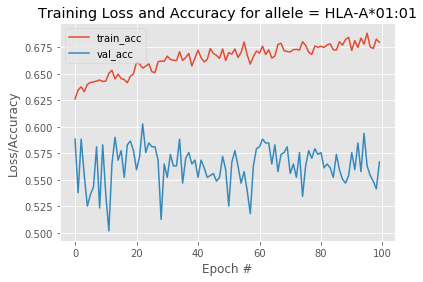

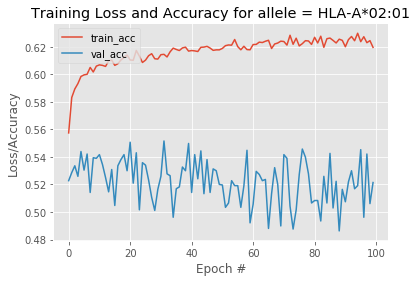

In [555]:
results = pd.DataFrame(columns = ("allele", "val_acc", "pearson_r", "f1_score"))



for x in hla_sample:
    
    allele = x
    epochs=100

    history, metrics, results = model_fit_allele(allele=allele, 
                     data = HLA, 
                     test_frac=0.1, 
                     n_class=4, 
                     model=model, 
                     epochs=epochs, 
                     results=results)

In [556]:
results

,allele,val_acc,pearson_r,f1_score
0,HLA-A*01:01,0.637398,0.333489,0.619332
1,HLA-A*02:01,0.626218,0.343718,0.621339


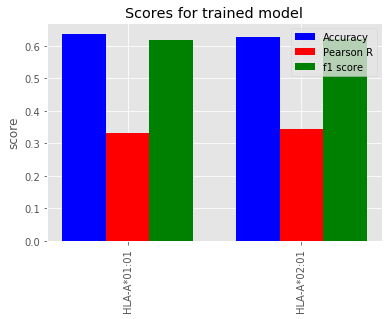

In [557]:
ind = np.arange(len(results["allele"]))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, results["val_acc"], width,color='Blue', label='Accuracy')
rects2 = ax.bar(ind, results["pearson_r"], width, color='Red', label='Pearson R')
rects3 = ax.bar(ind + width, results["f1_score"], width, color='Green', label='f1 score')

labels = results["allele"]
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('score')
ax.set_title('Scores for trained model')
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

plt.show()